<a href="https://colab.research.google.com/github/affanmalik02/dlmusicplaylist/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation
This section imports songs from the [GTZAN dataset](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification). This has 30 second clips of 100 songs from 10 genres. The songs come pre-processed in the Mel-Spectrogram format which is what we will use to train our CNN. The path to the spectrograms is saved in the spectrogramsPath variable. The (genre, image-array) pairs are saved into the array called data.

In [1]:
import kagglehub
import pandas as pd
import os
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

In [2]:
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)
spectrogramsPath = path + '/Data/images_original'

100%|██████████| 1.21G/1.21G [00:14<00:00, 91.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [3]:
genre_spectrogram_pairs = []
base_path_length = len(spectrogramsPath) + 1

for root, dirs, files in os.walk(spectrogramsPath):
    genre = root[base_path_length:]
    for file in files:
        file_path = os.path.join(spectrogramsPath, genre, file)
        img = Image.open(file_path)
        spectrogram_array = np.array(img)

        genre_spectrogram_pairs.append((genre, spectrogram_array))

print(f"Total spectrograms processed: {len(genre_spectrogram_pairs)}")
print(f"Data entry: {genre_spectrogram_pairs[0]}")

Total spectrograms processed: 999
Data entry: ('disco', array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255,

Genre: disco Observation Count: 100
Genre: pop Observation Count: 100
Genre: jazz Observation Count: 99
Genre: reggae Observation Count: 100
Genre: blues Observation Count: 100
Genre: rock Observation Count: 100
Genre: hiphop Observation Count: 100
Genre: metal Observation Count: 100
Genre: classical Observation Count: 100
Genre: country Observation Count: 100


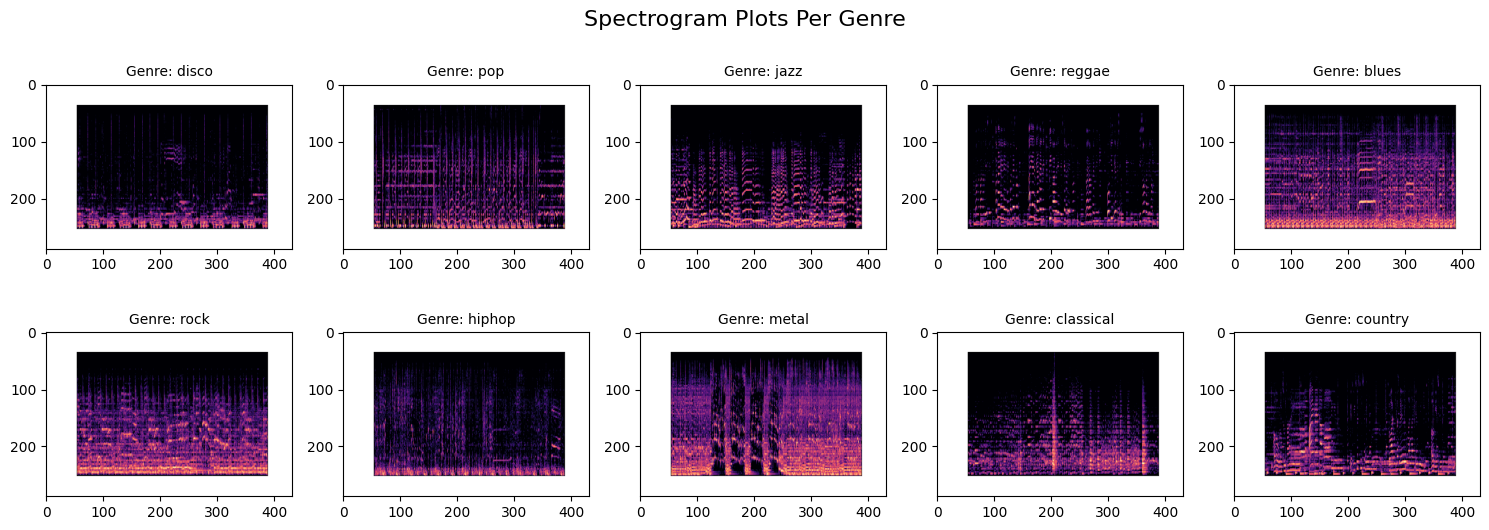

In [4]:
unique_genre_spectrograms = {}
genre_class_count = defaultdict(int)
for genre, img_array in genre_spectrogram_pairs:
    genre_class_count[genre] += 1
    if genre not in unique_genre_spectrograms:
        unique_genre_spectrograms[genre] = img_array

# printing genre wise information
for genre,count in genre_class_count.items():
  print(f"Genre: {genre} Observation Count: {count}")

unique_genres = list(unique_genre_spectrograms.keys())
unique_images = list(unique_genre_spectrograms.values())

num_genres = 10
columns = 5
rows = 2

# Create a figure for the grid of spectrograms
fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 3))
fig.suptitle("Spectrogram Plots Per Genre", fontsize=16, y=0.92)

for i, (genre, img_array) in enumerate(zip(unique_genres, unique_images)):
    row, col = divmod(i, columns)
    ax = axes[row, col]

    ax.imshow(img_array, cmap='viridis')
    ax.set_title(f"Genre: {genre}", fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [5]:
"""
The goal of this function is to ensure that the inputs are consistent in size
before being passed into the CNN network. Converting the image to grayscale
simplifies the input by reducing the number of channels, which are not required
for our task.
"""
def preprocess_spectrogram(image_array, target_size=(128, 130)):
    """
    Preprocess spectrograms by resizing and normalizing them.
    Args:
        image_array (ndarray): Input spectrogram as a numpy array.
        target_size (tuple): Target size (height, width) for resizing.
    Returns:
        ndarray: Processed spectrogram.
    """
    img = Image.fromarray(image_array)
    img = img.resize((target_size[1], target_size[0]), Image.Resampling.LANCZOS)  # (width, height)
    img = ImageOps.grayscale(img)  # Convert to grayscale
    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    return img_array

"""
This function calculates a single time segment for the spectrogram being
processed.

image_array --> 2D spectrogram.
segment_length --> Defines the number of columns in the segment (time bins).
overlap --> Fraction of overlap between consecutive segments. Set to
            0.5 as in the baseline reference paper.
"""
def segment_spectrogram(image_array, segment_length, total_bins, overlap=0.5):
    step_size = int(segment_length * (1 - overlap))  # Sliding step for segmentation
    segments = []
    num_segments = (total_bins - segment_length) // step_size + 1  # Calculate max number of valid segments

    for i in range(num_segments):
        start = i * step_size
        end = start + segment_length
        if end <= image_array.shape[1]:  # Ensure the segment fits within the spectrogram
            segment = image_array[:, start:end]
            segments.append(segment)
    return segments


# Parameters
segment_length = 130
track_duration = 30
time_per_bin = 0.023
total_bins = int(track_duration / time_per_bin)
overlap = 0.5

preprocessed_data = []
for genre, img_array in genre_spectrogram_pairs:
    preprocessed_img = preprocess_spectrogram(img_array, target_size=(128, total_bins))
    segments = segment_spectrogram(preprocessed_img, segment_length, total_bins, overlap)
    for segment in segments:
        preprocessed_data.append((genre, segment))

# **Spectogram Dataset**

In [6]:
class SpectrogramDataset(Dataset):
    def __init__(self, preprocessed_data, label_mapping):
        self.data = preprocessed_data
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        genre, segment = self.data[idx]
        label = self.label_mapping[genre]
        segment_tensor = torch.tensor(segment, dtype=torch.float32).unsqueeze(0) # adding the channel for grayscale
        return segment_tensor, label

In [7]:
# Label Mapping
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
label_mapping = {genre: idx for idx, genre in enumerate(genres)}

'''
The data splitting has been done as per how it was performed in the reference paper
'''

# Split data into train (50%) and temp (50%)
train_data, temp_data = train_test_split(preprocessed_data, test_size=0.5, random_state=42)
# Split temp into validation (20%) and test (30%)
val_data, test_data = train_test_split(temp_data, test_size=0.6, random_state=42)
print(f"Train Size: {len(train_data)}, Validation Size: {len(val_data)}, Test Size: {len(test_data)}")

#datasets
train_dataset = SpectrogramDataset(train_data, label_mapping)
val_dataset = SpectrogramDataset(val_data, label_mapping)
test_dataset = SpectrogramDataset(test_data, label_mapping)

#DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train Size: 9490, Validation Size: 3796, Test Size: 5695


#**Spectogram Model**

In [8]:
"""
The main drawback of the baseline reference paper was that it primarily focused on the temporal features
of the spectrogram without much emphasis on the spectral features, which are equally important.

To address this limitation, this model introduces a parallel architecture with two separate branches:
- The Temporal branch processes features related to changes over time.
- The Spectral branch processes features related to frequency components.

The outputs from these two branches are combined into a dense feature map, which is then passed through
a softmax layer to predict the probabilities for each genre.
"""

class SpectrogramCNN(nn.Module):
    def __init__(self, input_shape, num_classes, dropout_prob=0.3):
        super(SpectrogramCNN, self).__init__()

        # Temporal branch: Focuses on changes over time (horizontal features)
        self.temporal_branch = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(1, 7), padding=(0, 3)),  # Horizontal filters
            nn.BatchNorm2d(64),  # Normalize feature maps to stabilize training
            nn.ReLU(inplace=True),  # Activation function for non-linearity
            nn.Conv2d(64, 128, kernel_size=(1, 7), padding=(0, 3)),  # More horizontal filters
            nn.BatchNorm2d(128),  # Further normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2))  # Reduce feature map size (height and width)
        )

        # Spectral branch: Focuses on frequency components (vertical features)
        self.spectral_branch = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(7, 1), padding=(3, 0)),  # Vertical filters
            nn.BatchNorm2d(64),  # Normalize feature maps
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=(7, 1), padding=(3, 0)),  # More vertical filters
            nn.BatchNorm2d(128),  # Further normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2))  # Reduce feature map size (height and width)
        )

        # Combine branches: Merge temporal and spectral features
        self.combine_branches = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1),  # 1x1 convolution to reduce the number of channels
            nn.BatchNorm2d(128),  # Normalize the combined feature maps
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_prob)  # Apply dropout for regularization
        )

        # Final classifier: Predict genre probabilities
        self.classifier = nn.Sequential(
            nn.Conv2d(128, num_classes, kernel_size=1),  # Reduce channels to the number of classes
            nn.AdaptiveAvgPool2d(1)  # Global average pooling to output 1x1 feature maps
        )

    def forward(self, x):
        """
        Forward pass through the network.
        Args:
            x (Tensor): Input spectrogram segment.
        Returns:
            Tensor: Log probabilities for each genre.
        """
        temp_out = self.temporal_branch(x)
        spec_out = self.spectral_branch(x)

        # Combine the outputs from both branches along the channel dimension
        combined_features = torch.cat([temp_out, spec_out], dim=1)
        # Further process combined features
        combined_features = self.combine_branches(combined_features)
        # Classify using the final layer
        logits = self.classifier(combined_features).squeeze(-1).squeeze(-1)  # Remove extra dimensions
        # Return log probabilities for each class
        return F.log_softmax(logits, dim=1)



# Training

In [9]:
def train_with_validation(model, train_loader, val_loader, learning_rate=0.001, epochs=50, patience=5):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move the model to the appropriate device

    # Define optimizer, learning rate scheduler, and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
    criterion = nn.CrossEntropyLoss()

    # Initialize variables for tracking best validation loss and early stopping
    best_val_loss = float('inf')
    patience_counter = 0

    print("Starting Training")

    for epoch in range(epochs):

        # ===== Training Phase =====
        model.train()
        train_loss, train_correct = 0.0, 0  # Initialize training metrics

        for inputs, labels in train_loader:
            # Move data to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass: compute predictions
            optimizer.zero_grad()
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass: compute gradients and update weights
            loss.backward()
            optimizer.step()

            # Update training metrics
            train_loss += loss.item() * inputs.size(0)
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()

        # Calculate average training loss and accuracy
        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)

        # ===== Validation Phase =====
        model.eval()
        val_loss, val_correct = 0.0, 0  # Initialize validation metrics

        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in val_loader:
                # Move data to the same device as the model
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass: compute predictions
                outputs = model(inputs)

                # Compute the loss
                loss = criterion(outputs, labels)

                # Update validation metrics
                val_loss += loss.item() * inputs.size(0)  # Accumulate weighted loss
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()  # Count correct predictions

        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

        # Step the learning rate scheduler
        scheduler.step()

        # ===== Early Stopping =====
        if val_loss < best_val_loss:
            # If validation loss improves, save the model and reset patience counter
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")  # Save the model with the best validation loss
        else:
            # If no improvement, increment patience counter
            patience_counter += 1

        if patience_counter >= patience:
            # Stop training if validation loss does not improve for 'patience' epochs
            print("Early stopping triggered.")
            break


In [1]:
# Initialize model
input_shape = (128, 130)
num_classes = 10
model = SpectrogramCNN(input_shape=input_shape, num_classes=num_classes)

# Train the model
train_with_validation(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    learning_rate=0.001,
    epochs=50,
    patience=5
)


NameError: name 'SpectrogramCNN' is not defined

# Graphs / Experiments

Graphs: \\
Compare spectrograms from songs in playlist. \\

Experiments: \\
Multiple graphs of different numbers of paraments for the hidden layers. \\
Experiments with hyperparameters and different optimizers. \\


Experiment #1: From a list of learning rates, print out the training and validation losses to see which one is the best

In [11]:
learning_rates = [0.0001, 0.001, 0.01, 0.1] # CHANGE THIS
results = {}

# loop over all learning rates
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")

    # TODO: initialize optimizer with the current learning rate
    # add this accordingly after MODEL section is done
    optimizer =

    # train model and get the losses
    model, train_losses, val_losses = train_model(model, data, optimizer, loss_fn) #TODO: define loss_fn
    results[lr] = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }

# plot results
for lr, losses in results.items():
    plt.figure(figsize=(8, 5))
    plt.plot(losses['train_losses'], label='Train Loss')
    plt.plot(losses['val_losses'], label='Validation Loss')
    plt.title(f"Learning Rate: {lr}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

SyntaxError: invalid syntax (<ipython-input-11-4dc9517a6e34>, line 10)

Experiment #2: